In [1]:
import os
import pymongo

import pandas as pd
import numpy as np

from opply_resources import collection_payload

from scipy.stats import skew
from sklearn.preprocessing import RobustScaler

In [2]:
import cufflinks as cf
cf.go_offline()

In [3]:
collection_payload.keys()

dict_keys(['quotes_ernest', 'requests_ernest'])

#### Read in data from collection(s)

In [4]:
# receive payload
quote_collection = collection_payload['quotes_ernest']
request_collection = collection_payload['requests_ernest']

In [5]:
# convert to dataframe-friendly format
quote_data = list(quote_collection.find())
request_data = list(request_collection.find())

# ...and then create dataframes
quotes_df = pd.DataFrame(quote_data)
requests_df = pd.DataFrame(request_data)

In [6]:
quotes_df.head(2)

,_id,Request UUID,Quote Unit Price,Status,Decline Reason,Documents Provided,Quote Delay
0,666ade13e6cdb11d646428a1,3f37c3c6-fd5e-4fb1-b61d-544a7e5fbd30,7.61,Available,NaN,Yes,2
1,666ade13e6cdb11d646428a2,3f37c3c6-fd5e-4fb1-b61d-544a7e5fbd30,14.91,Declined,pricing,Yes,0


In [7]:
requests_df.head(2)

,_id,Request UUID,Request Name,Request Category,Current Unit Price,Target Unit Price,Supply Priority
0,666ade13e6cdb11d64642be2,2a0c4e3e-ad49-4963-8b4d-cd7bc2178265,Dried leaves of Tulsi Vana - Ocimum gratissimum.,"Herbs, Spices & Seasonings",10.0,10.0,Quality
1,666ade13e6cdb11d64642be3,3f37c3c6-fd5e-4fb1-b61d-544a7e5fbd30,Fava Bean Protein Isolate 90%,Additives & Preservatives,6.0,3.0,Price


### Perform Data Cleaning

In [8]:
requests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _id                 511 non-null    object 
 1   Request UUID        511 non-null    object 
 2   Request Name        511 non-null    object 
 3   Request Category    500 non-null    object 
 4   Current Unit Price  511 non-null    float64
 5   Target Unit Price   511 non-null    float64
 6   Supply Priority     372 non-null    object 
dtypes: float64(2), object(5)
memory usage: 28.1+ KB


In [9]:
requests_df.describe()

,Current Unit Price,Target Unit Price
count,511.000000,511.000000
mean,39.428787,32.849902
std,534.629677,445.406012
min,0.010000,0.010000
25%,1.665000,1.600000
50%,4.000000,3.500000
75%,10.000000,8.900000
max,12000.000000,10000.000000


In [10]:
set(requests_df['Request UUID'].value_counts()) # check for genuine uniqueness

{1}

In [11]:
set(quotes_df['Request UUID'].value_counts()) # lines up with one to many relationship of requests to quotes

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12}

##### Inspect outliers via z-score (METHOD PROVED NOT 100% ROBUST)

In [12]:
def z_score_outlier_inspect(data,variables,threshold=3):
    """
    Simple z-score calculation for outlier detection
    """
    z_score_outlier_indices = {}

    for var in variables:
        srs = data[var]

        mean = np.mean(srs)
        std_dev = np.std(srs)
        z_scores = np.abs((srs-mean)/std_dev)
        outlier_indices = np.where(z_scores > threshold)[0]

        z_score_outlier_indices[var] = outlier_indices

    return z_score_outlier_indices

In [13]:
def outlier_plot(data,detected_outlier_vars):
    '''
    Return a dictionary of explanatory vars and their associated plots.
    '''
    return_plots = {}
    for var in detected_outlier_vars:
        # define base plot
        outlier_scatter_plot = data[var].iplot(kind='scatter',mode='markers',asFigure=True, 
                                              title=f"Original {var} with Outliers Marked",
                                              xTitle="index",yTitle=f"{var}",
                                              theme='solar')
        # Place markers on chart
        for idx in detected_outlier_vars.get(var):
            outlier_value = data.iloc[idx][var]
            color = "red"
            outlier_scatter_plot.add_scatter(x=[idx], 
                                             y=[outlier_value],mode='markers', 
                                             marker=dict(color=color, size=10, symbol="x"), 
                                             showlegend=False, name=f"idx {idx}")

        return_plots[var] = outlier_scatter_plot

    return return_plots

In [14]:
# get dictionary of z_score calculated outliers
z_score_outlier_dict_REQUESTS = z_score_outlier_inspect(data=requests_df.loc[requests_df['Current Unit Price']<12000],
                                                        variables=['Current Unit Price','Target Unit Price'])

# using all values below 12000 above, as it is a clear outlier

In [15]:
z_score_outlier_dict_REQUESTS # indices of where outliers are detected as determined above

{'Current Unit Price': array([165, 249, 427, 436], dtype=int64),
 'Target Unit Price': array([165, 427, 436], dtype=int64)}

In [16]:
# # get dictionary of plots
# z_score_plotting_dict_REQUESTS = outlier_plot(data=requests_df,
#                                               detected_outlier_vars=z_score_outlier_dict_REQUESTS)
# # ...and then plot for visual confirmation
# for ky in z_score_plotting_dict_REQUESTS.keys():
#     z_score_plotting_dict_REQUESTS[ky].show()

##### IQR Outlier detection

In [17]:
def adjust_thresholds_based_on_data(data, variables):
    adjusted_thresholds = {}
    scaler = RobustScaler()

    for var in variables:
        srs = data[var].copy()
        srs.fillna(0.0, inplace=True)

        # normalise the data using RobustScaler
        norm_srs = scaler.fit_transform(srs.values.reshape(-1,1)).flatten()

        median = np.median(norm_srs)
        mad = np.median(np.abs(norm_srs - median))

        # adjust outlier detection thresholds based on data characteristics
        multiplier = 1.5  # starting multiplier
        skewness = skew(norm_srs)
        if abs(skewness) > 1.0:
            multiplier *= 2.0  # reasonable increase in multiplier for highly skewed data
            
        # adjust thresholds based on interquartile range (IQR) and multiplier
        lower_bound = median - multiplier * mad
        upper_bound = median + multiplier * mad
        
        # Store adjusted thresholds for this variable
        adjusted_thresholds[var] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}
    
    return adjusted_thresholds

In [18]:
def IQR_outlier_inspect(data,variables):
    """
    Takes a dataset and a set of variables to iterate through

    Breaks the data into individual series' , normalises them and then calculates median, MAD, and IQR

    taking into account the 'skewness' of the data.

    Returns a nested dict of {key=variable : value = {lower bound, upper bound}}
    """
    detected_variable_outliers = {}

    adjusted_thresholds = adjust_thresholds_based_on_data(data=data, variables=variables)

    for var in variables:
        srs = data[var].copy()
        srs.fillna(0.0, inplace=True)
        
        # norm'ing the data using RobustScaler
        scaler = RobustScaler()
        norm_srs = scaler.fit_transform(srs.values.reshape(-1, 1)).flatten()
        
        # adjusted thresholds for this explanatory variable
        thresholds = adjusted_thresholds[var]

        # detected outliers based on adjusted thresholds
        outlier_indices = data[(norm_srs < thresholds['lower_bound']) | (norm_srs > thresholds['upper_bound'])].index

        detected_variable_outliers[var] = outlier_indices

    # return only non-empty elements
    non_empty_elements = {key: value for key, value in detected_variable_outliers.items() if len(value) > 0 and len(value) != len(srs)}

    return non_empty_elements

In [19]:
IQR_outlier_dict_REQUESTS = IQR_outlier_inspect(data=requests_df,
                                                variables=['Current Unit Price','Target Unit Price'])

IQR_outlier_dict_QUOTES = IQR_outlier_inspect(data=quotes_df,variables=['Quote Unit Price','Quote Delay'])

In [20]:
IQR_outlier_dict_REQUESTS

{'Current Unit Price': Index([  2,   7,   9,  12,  18,  28,  29,  41,  42,  43,
        ...
        475, 476, 477, 478, 487, 489, 492, 497, 498, 506],
       dtype='int64', length=107),
 'Target Unit Price': Index([  2,   7,   9,  12,  18,  28,  29,  41,  42,  43,
        ...
        472, 473, 474, 475, 476, 477, 478, 497, 498, 506],
       dtype='int64', length=113)}

In [21]:
IQR_outlier_dict_QUOTES

{'Quote Unit Price': Index([  5,   6,  14,  15,  24,  26,  39,  52,  60,  64,
        ...
        793, 794, 795, 796, 798, 799, 800, 801, 804, 808],
       dtype='int64', length=161),
 'Quote Delay': Index([  3,  11,  12,  13,  15,  22,  23,  24,  35,  36,
        ...
        718, 732, 733, 734, 772, 802, 803, 805, 816, 820],
       dtype='int64', length=225)}

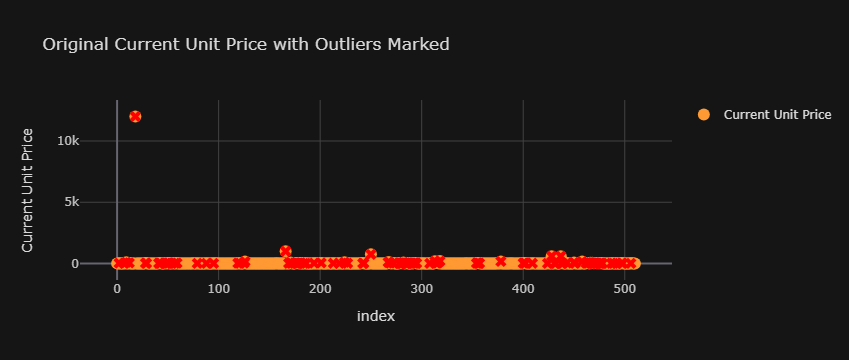

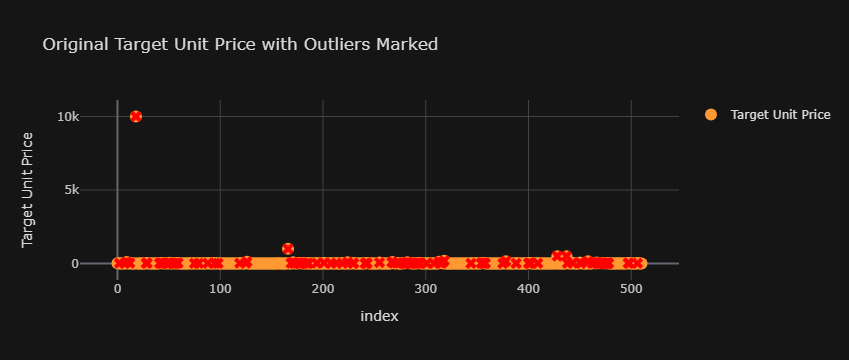

In [22]:
# get dictionary of plots
IQR_plotting_dict_REQUESTS = outlier_plot(data=requests_df,
                                          detected_outlier_vars=IQR_outlier_dict_REQUESTS)
# ...and then plot for visual confirmation
for ky in IQR_plotting_dict_REQUESTS.keys():
    IQR_plotting_dict_REQUESTS[ky].show()

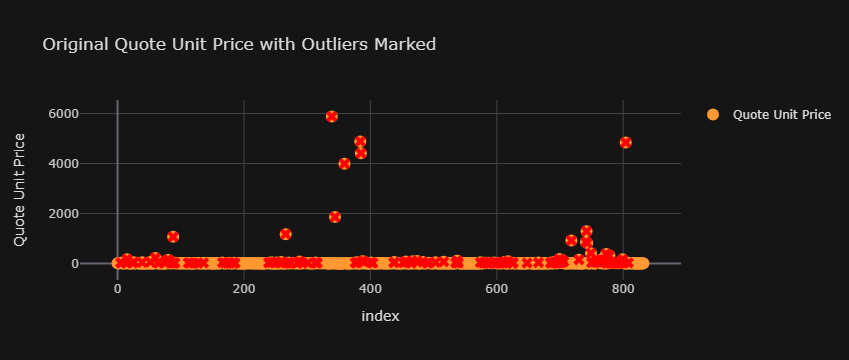

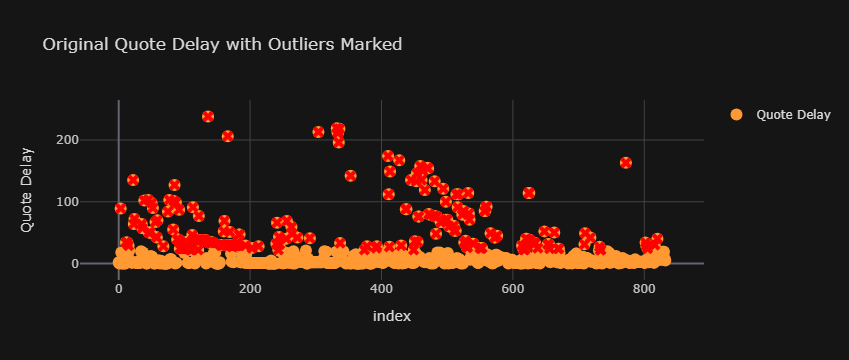

In [23]:
# get dictionary of plots
IQR_plotting_dict_QUOTES = outlier_plot(data=quotes_df,
                                       detected_outlier_vars=IQR_outlier_dict_QUOTES)
# ...and then plot for visual confirmation
for ky in IQR_plotting_dict_QUOTES.keys():
    IQR_plotting_dict_QUOTES[ky].show()

The outliers as determined by the quote delay seem more like a nuance of the data rather than something to be accounted for. For now, only going to subset by the prices.

### !!NOTE - This is an imperfect method, but for expediency I will continue with this subset.

Ideally I would engage in iterative development of a more appropriate outlier detection method, and potentially perform linear interpolation for time-series or appropriately ordered data

In [24]:
# Subsetting by unit price

requests_df_subset = requests_df.drop(IQR_outlier_dict_REQUESTS['Current Unit Price'])
quotes_df_subset = quotes_df.drop(IQR_outlier_dict_QUOTES['Quote Unit Price'])

## Save Silver Data 

In [25]:
requests_df_subset.to_pickle('.\Silver Data\silver_requests.pkl')
quotes_df_subset.to_pickle('.\Silver Data\silver_quotes.pkl')